## Welcome to the `Segformer Starter Block` Workshop!

In this workshop, we'll learn about building blocks of Segformer architecture.
1. **Overlap Patch Embedding**. A method to convert images to sequence of overlapping patches
2. **Efficient Self-Attention** - 1st Core component of all Transformer based models.
3. **Mix-FeedForward module** - 2nd core component of Transformer models. Along with Self-Attention, forms single Transformer block
4. **Transformer block** - Self-attention + Mix FFN + Layer Norm forms a basic Tranformer block

We'll cover these concepts in this notebook

In [1]:
!pip install einops
!pip install timm

Looking in indexes: https://pypi.zooxlabs.com/simple/
Looking in indexes: https://pypi.zooxlabs.com/simple/


In [2]:
# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# Segformer specific imports
from einops import rearrange

## 1. Overlap Patch Embedding


- Vision Transformers (ViT) pioneered the idea of Overlapping image patches.
- `ViT uses patches of size 16x16 along with positional encodings`. Hence the paper name (Image is worth 16x16 words)
- **In Segformer, authors propose smaller patch size (4x4) for semantic segmentation as its a dense prediction task**
- **No positional encoding for patches**

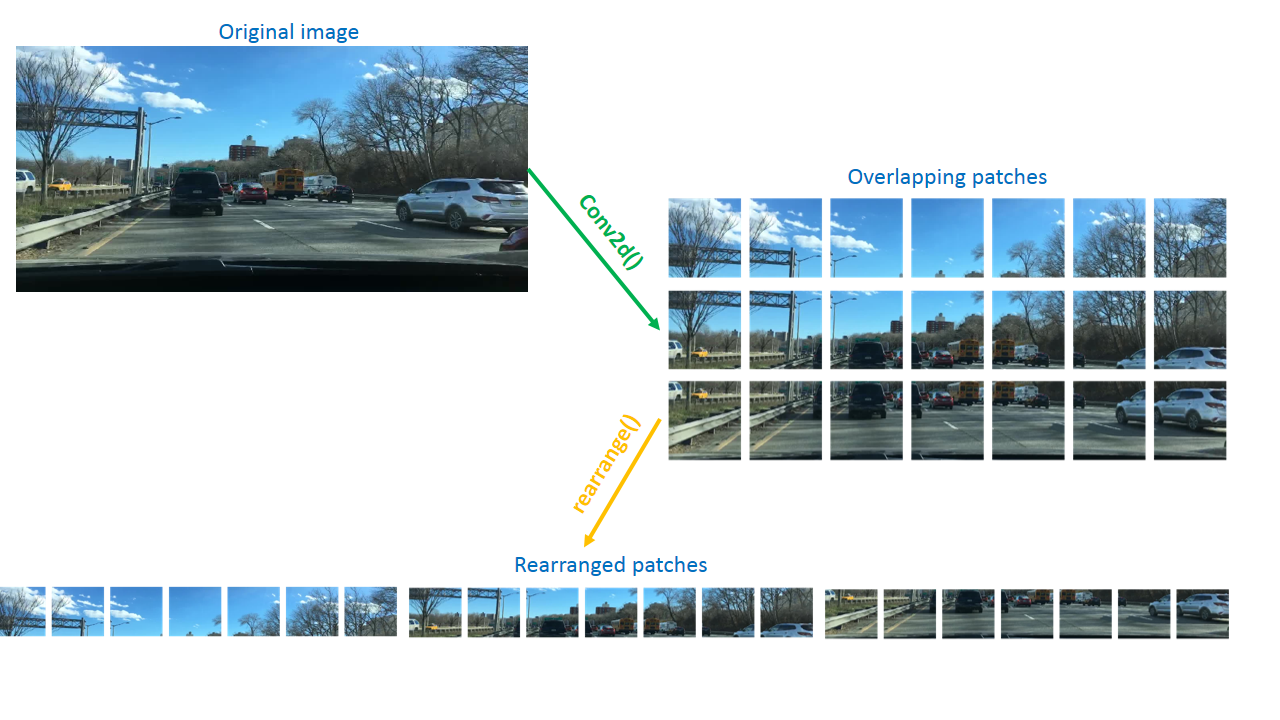

In [4]:
class overlap_patch_embed(nn.Module):
    def __init__(self, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        self.patch_size= patch_size
        self.proj = nn.Conv2d(in_channels=in_chans,out_channels=embed_dim, kernel_size=patch_size,stride=stride, padding=(patch_size//2,patch_size//2)) # Output: (I-K + Pstart + Pend)/2 +1
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x= self.proj(x)
        _,_,h,w = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c') #rearrange the volumetric convolution to flatten with h w into single row
        x= self.norm(x)
        return x, h ,w

In [5]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/test_img.jpeg

--2024-08-17 20:53:17--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/test_img.jpeg
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 16.12.19.22, 3.5.224.123
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|16.12.19.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23690 (23K) [image/jpeg]
Saving to: ‘test_img.jpeg’

test_img.jpeg       100%[===================>]  23.13K  --.-KB/s    in 0.001s  

2024-08-17 20:53:18 (30.9 MB/s) - ‘test_img.jpeg’ saved [23690/23690]



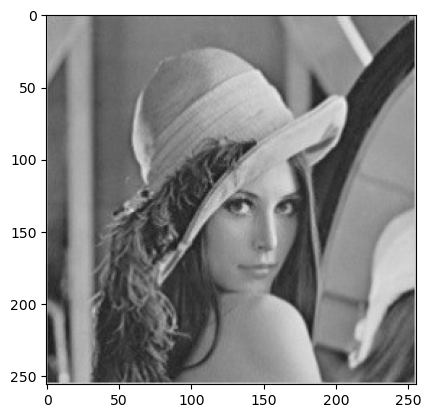

In [8]:
import matplotlib.pyplot as plt
import cv2
input_image = cv2.imread('test_img.jpeg')
plt.imshow(input_image)
plt.show()

In [10]:
from torchvision import transforms
convert_tensor = transforms.ToTensor()

overlap_patch_embed_input = convert_tensor(input_image).reshape(1,3,256,256)
print("overlap_patch_embed_input.shape", overlap_patch_embed_input.shape)


overlap_patch_embed_input.shape torch.Size([1, 3, 256, 256])


In [11]:
model = overlap_patch_embed(patch_size= 7, stride =4, in_chans =3, embed_dim = 64)

In [12]:
overlap_patch_embed_output, _, _ = model(overlap_patch_embed_input)
print("overlap_patch_embed_output.shape", overlap_patch_embed_output.shape)

overlap_patch_embed_output.shape torch.Size([1, 4096, 64])


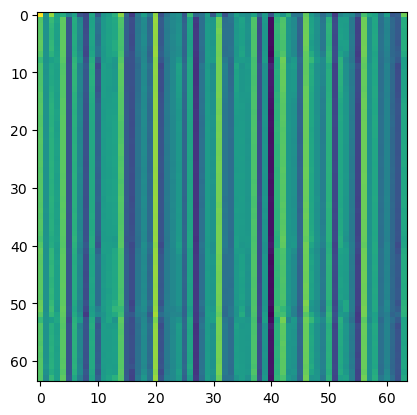

In [13]:
row = 0
col = 0
plt.imshow(overlap_patch_embed_output[0].detach().numpy()[row:row+64,col:col+64])
plt.show()

Okay, because we have used a convolution with untrained weights, we might as well use a dummy input:

In [14]:
overlap_patch_embed_input = torch.Tensor(1, 3, 256, 256)

From which the process is the same:

In [15]:
model = overlap_patch_embed(patch_size= 7, stride =4, in_chans =3, embed_dim = 64)
overlap_patch_embed_output, _, _ = model(overlap_patch_embed_input)
print("overlap_patch_embed_input.shape", overlap_patch_embed_input.shape)
print("overlap_patch_embed_output.shape", overlap_patch_embed_output.shape)

overlap_patch_embed_input.shape torch.Size([1, 3, 256, 256])
overlap_patch_embed_output.shape torch.Size([1, 4096, 64])


## 2. Efficient Multi-head Self-Attention

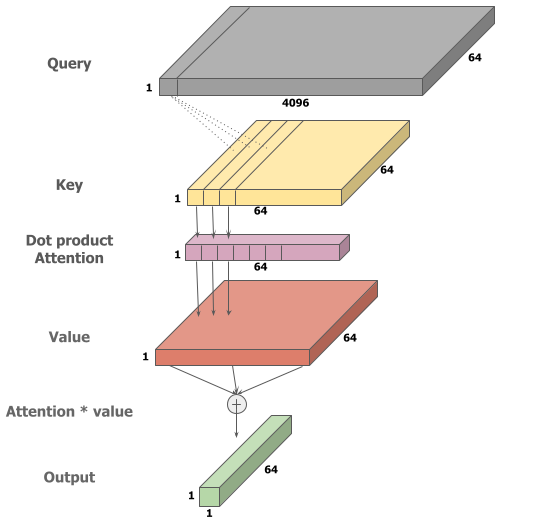

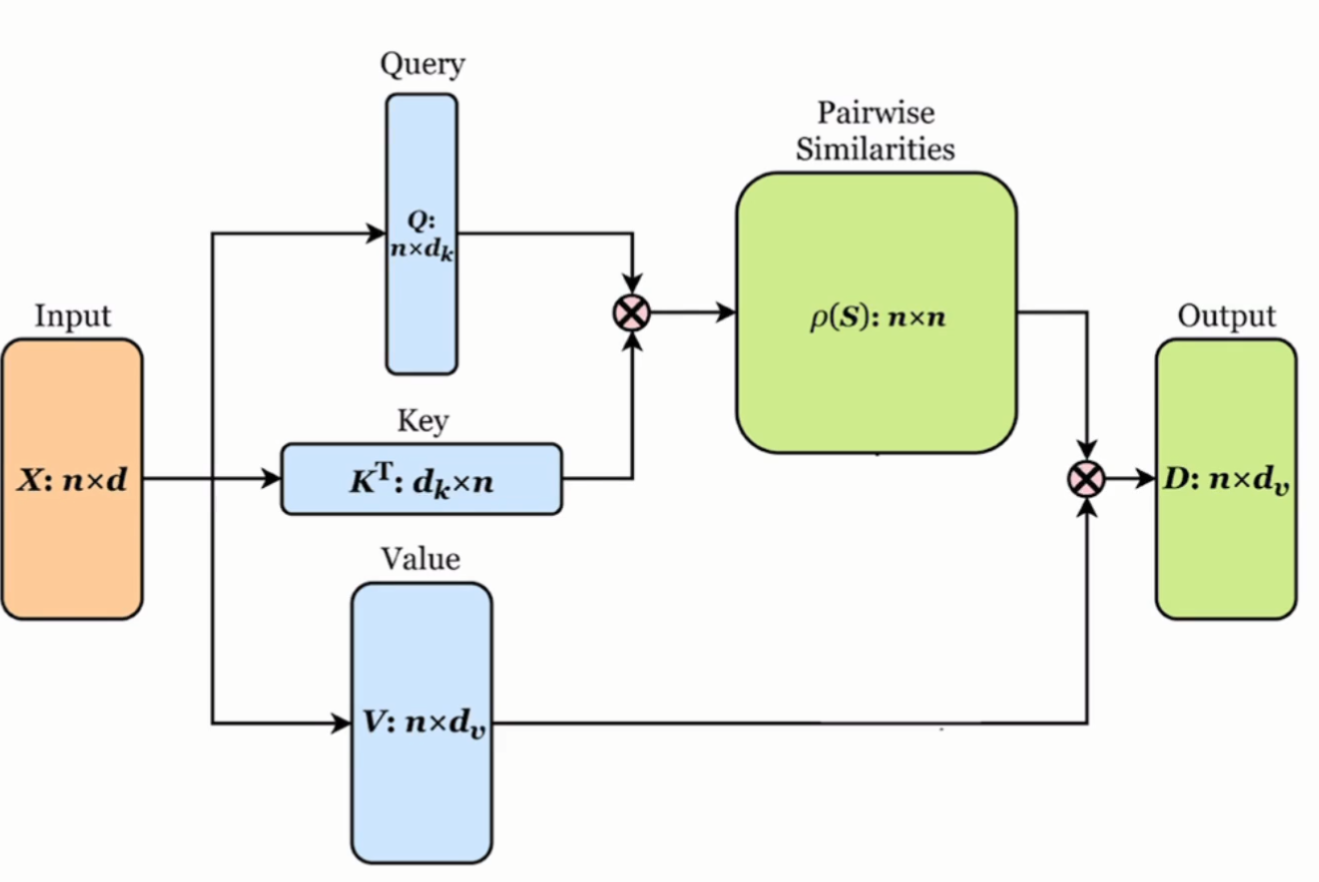

In [39]:

# Implement the forward function, and run:
# Reshape Q into [4096, 64]
# Scale K and V if the ratio is >1
# Reshape K and Key into [64,64] each
# Multiply Q and K
# Run a Softmax
# Multiply Attention with V
# Apply a final projection layer and dropout

# The output must be in dimensions  [4096, 64].
class efficient_self_attention(nn.Module):
    def __init__(self, attn_dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        assert attn_dim % num_heads == 0, f'expected attn_dim {attn_dim} to be a multiple of num_heads {num_heads}'
        self.attn_dim = attn_dim
        self.num_heads = num_heads
        self.dropout_p = dropout_p
        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(attn_dim, attn_dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(attn_dim)

        # Multi-head Self-Attention using dot product
        # Query - Key Dot product is scaled by root of head_dim
        self.q = nn.Linear(attn_dim, attn_dim, bias=True)
        self.kv = nn.Linear(attn_dim, attn_dim * 2, bias=True)
        self.scale = (attn_dim // num_heads) ** -0.5

        # Projecting concatenated outputs from
        # multiple heads to single `attn_dim` size
        self.proj = nn.Linear(attn_dim, attn_dim)

    def forward(self, x, h, w):
        q=self.q(x)
        q= rearrange(q,('b hw (m c)-> b m hw c'), m= self.num_heads)
        print(f'q.shape = {q.shape}')

        if self.sr_ratio>1:
            x= rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
            x= self.sr(x)
            x= rearrange(x, 'b c h w -> b (h w) c')
            x= self.norm(x)
            print(f"After sr, x.shape= {x.shape}")

        x= self.kv(x)
        x= rearrange(x,('b d (a m c)-> a b m d c'), a=2, m= self.num_heads)
        print(f'After rearranging x.shape = {x.shape}')
        k,v = x[0], x[1]
        print(f'k.shape = {k.shape}')
        print(f'v.shape = {v.shape}')

        attn = (q@ k.transpose(-2,-1))* self.scale
        attn = attn.softmax(dim =-1)
        print(f'attn.shape = {attn.shape}')

        x = attn@v
        print(f'attn@v.shape = {x.shape}')
        x = rearrange(x, 'b m hw c -> b hw (m c)')
        print(f'After rearranging = {x.shape}')
        x= self.proj(x)
        x= F.dropout(x, p=self.dropout_p, training=self.training)
        return x



In [40]:
## Test with sample inputs
efficient_self_attention_input = torch.Tensor(1, 4096, 64)
model = efficient_self_attention(attn_dim= 64, num_heads = 1,
                                 dropout_p = 0, sr_ratio = 8)
efficient_self_attention_output = model(efficient_self_attention_input, h=64, w = 64)
print("efficient_self_attention_input.shape", efficient_self_attention_input.shape)
print("efficient_self_attention_output.shape", efficient_self_attention_output.shape)

q.shape = torch.Size([1, 1, 4096, 64])
After sr, x.shape= torch.Size([1, 64, 64])
After rearranging x.shape = torch.Size([2, 1, 1, 64, 64])
k.shape = torch.Size([1, 1, 64, 64])
v.shape = torch.Size([1, 1, 64, 64])
attn.shape = torch.Size([1, 1, 4096, 64])
attn@v.shape = torch.Size([1, 1, 4096, 64])
After rearranging = torch.Size([1, 4096, 64])
efficient_self_attention_input.shape torch.Size([1, 4096, 64])
efficient_self_attention_output.shape torch.Size([1, 4096, 64])


## 3. Mix FeedForward Module

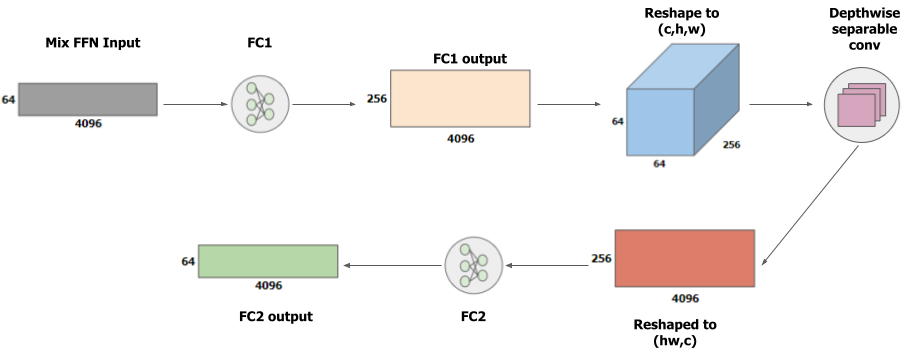

In [41]:
# Fully Connected
# 2D Convolution
# GeLU
# Dropout
# Fully Connected
# Dropout
class mix_feedforward(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, dropout_p = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)

        self.conv = nn.Conv2d(in_channels=hidden_features, out_channels=hidden_features, kernel_size=3, padding=(1,1), bias=True,groups=hidden_features)
        self.dropout_p = dropout_p

    def forward(self, x, h, w):
        x= self.fc1(x)
        x= rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x= self.conv(x)
        x= rearrange(x, 'b c h w -> b (h w) c')
        x= F.gelu(x)
        x= F.dropout(x, p=self.dropout_p, training=self.training)
        x= self.fc2(x)
        x= F.dropout(x, p=self.dropout_p, training=self.training)
        return x

In [42]:
## Test with sample inputs
mix_feedforward_input = torch.Tensor(1, 4096, 64)
model = mix_feedforward(in_features=64, out_features=64, hidden_features=256)
mix_feedforward_output = model(mix_feedforward_input, h=64, w = 64)
print("mix_feedforward_input.shape", mix_feedforward_input.shape)
print("mix_feedforward_output.shape", mix_feedforward_output.shape)

mix_feedforward_input.shape torch.Size([1, 4096, 64])
mix_feedforward_output.shape torch.Size([1, 4096, 64])


## 4. Transformer Block

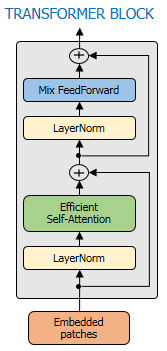

In [43]:
class transformer_block(nn.Module):
    def __init__(self, dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        # One transformer block is defined as :
        # Norm -> self-attention -> Norm -> FeedForward
        # skip-connections are added after attention and FF layers
        self.attn = efficient_self_attention(attn_dim=dim, num_heads=num_heads,
                    dropout_p=dropout_p, sr_ratio=sr_ratio)
        self.ffn = mix_feedforward( dim, dim, hidden_features=dim * 4, dropout_p=dropout_p)
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)


    def forward(self, x, h, w):
        # Norm --> Self Attn
        skip= x
        x= self.norm1(x)
        x= self.attn(x,h,w)
        x= x+ skip

        # Norm --> FeedForward
        skip = x
        x= self.norm2(x)
        x= self.ffn(x, h, w)
        x= x + skip
        return x

In [45]:
## Test with sample inputs
transformer_block_input = torch.Tensor(1, 4096, 64)
model = transformer_block(dim=64, num_heads=1, dropout_p=0.1, sr_ratio=8)
transformer_block_output = model(transformer_block_input, h=64, w = 64)
print("transformer_block_input.shape", transformer_block_input.shape)
print("transformer_block_output.shape", transformer_block_output.shape)

q.shape = torch.Size([1, 1, 4096, 64])
After sr, x.shape= torch.Size([1, 64, 64])
After rearranging x.shape = torch.Size([2, 1, 1, 64, 64])
k.shape = torch.Size([1, 1, 64, 64])
v.shape = torch.Size([1, 1, 64, 64])
attn.shape = torch.Size([1, 1, 4096, 64])
attn@v.shape = torch.Size([1, 1, 4096, 64])
After rearranging = torch.Size([1, 4096, 64])
transformer_block_input.shape torch.Size([1, 4096, 64])
transformer_block_output.shape torch.Size([1, 4096, 64])
